In [2]:
# Cell 1: Import required libraries
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import label, generate_binary_structure
from scipy.stats import ttest_ind

# Define paths
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
gca_dir = f'{results_dir}/gca_group_averages_exp2'  # Directory with your thresholded GCA images
output_dir = f'{results_dir}/gca_quantitative_exp2'
os.makedirs(output_dir, exist_ok=True)

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
# Cell 2: Load thresholded GCA images
def load_thresholded_images():
    """Load previously thresholded GCA images"""
    thresholded_imgs = {}
    
    for condition in ['tool', 'nontool']:
        for roi in ['pIPS', 'LO']:
            for hemi in ['left', 'right']:
                img_path = f'{gca_dir}/{condition}_{roi}_{hemi}_gca_thresh.nii.gz'
                if os.path.exists(img_path):
                    thresholded_imgs[f"{condition}_{roi}_{hemi}"] = nib.load(img_path)
                else:
                    print(f"Warning: {img_path} not found")
    
    return thresholded_imgs

thresholded_imgs = load_thresholded_images()
print(f"Loaded {len(thresholded_imgs)} thresholded GCA images")

Loaded 8 thresholded GCA images


In [ ]:
# Cell 2: Load thresholded GCA images
def load_thresholded_images():
    """Load previously thresholded GCA images"""
    thresholded_imgs = {}
    for condition in ['tool', 'nontool']:
        for roi in ['pIPS', 'LO']:
            for hemi in ['left', 'right']:
                img_path = f'{results_dir}/gca_group_averages_exp2_schaefer/{condition}_{roi}_{hemi}_gca_thresh_schaefer.nii.gz'
                if os.path.exists(img_path):
                    thresholded_imgs[f"{condition}_{roi}_{hemi}"] = nib.load(img_path)
                else:
                    print(f"Warning: {img_path} not found")
    
    return thresholded_imgs

thresholded_imgs = load_thresholded_images()
print(f"Loaded {len(thresholded_imgs)} thresholded GCA images")

Loaded 8 thresholded GCA images


In [22]:
# Cell 3: Load and apply standard Schaefer 200 atlas to GCA results
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
from nilearn.datasets import fetch_atlas_schaefer_2018

def load_schaefer_atlas(n_rois=200, yeo_networks=17):
    """Load the standard Schaefer atlas"""
    atlas = fetch_atlas_schaefer_2018(
        n_rois=n_rois, 
        yeo_networks=yeo_networks,
        resolution_mm=2
    )
    atlas_img = nib.load(atlas['maps'])
    labels = atlas['labels']
    
    print(f"Loaded Schaefer atlas with {n_rois} parcels and {yeo_networks} networks")
    return atlas_img, labels

def extract_roi_values(thresholded_imgs, atlas_img, atlas_labels):
    """Extract values from thresholded GCA images for each ROI in Schaefer atlas"""
    atlas_data = atlas_img.get_fdata()
    
    # Create a dictionary to store results
    roi_values = {}
    
    # Process each thresholded image
    for img_key, img in thresholded_imgs.items():
        img_data = img.get_fdata()
        
        # Initialize a dictionary for this image
        roi_values[img_key] = {}
        
        # Extract values for each ROI in the atlas (1-based indexing)
        for roi_value in range(1, len(atlas_labels) + 1):
            roi_mask = atlas_data == roi_value
            
            # Extract values from the GCA image within this ROI
            if np.any(roi_mask):
                values = img_data[roi_mask]
                roi_name = atlas_labels[roi_value - 1]  # Convert to 0-based index
                roi_values[img_key][roi_name] = values
    
    return roi_values

# Load standard Schaefer atlas (200 parcels, 17 networks)
atlas_img, atlas_labels = load_schaefer_atlas()

# Extract ROI values from thresholded images
roi_values = extract_roi_values(thresholded_imgs, atlas_img, atlas_labels)

Loaded Schaefer atlas with 200 parcels and 17 networks



CREATING GCA ANATOMICAL ORGANIZATION VISUALIZATION - pIPS AND LO SEEDS
Using LOOV and Bootstrapping (10 iterations)
Filtering for pIPS and LO seed ROIs and averaging left and right hemispheres...
Found 8 seed keys: ['tool_pIPS_left', 'tool_pIPS_right', 'tool_LO_left', 'tool_LO_right', 'nontool_pIPS_left', 'nontool_pIPS_right', 'nontool_LO_left', 'nontool_LO_right']
Processing tool_pIPS (averaging L and R hemispheres)...
  Running bootstrap for ROI b'17Networks_LH_VisCent_ExStr_1'...
  Running bootstrap for ROI b'17Networks_LH_VisCent_ExStr_2'...
  Running bootstrap for ROI b'17Networks_LH_VisCent_Striate_1'...
  Running bootstrap for ROI b'17Networks_LH_VisCent_ExStr_3'...
  Running bootstrap for ROI b'17Networks_LH_VisCent_ExStr_4'...
  Running bootstrap for ROI b'17Networks_LH_VisCent_ExStr_5'...
  Running bootstrap for ROI b'17Networks_LH_VisPeri_ExStrInf_1'...
  Running bootstrap for ROI b'17Networks_LH_VisPeri_ExStrInf_2'...
  Running bootstrap for ROI b'17Networks_LH_VisPeri_ExS

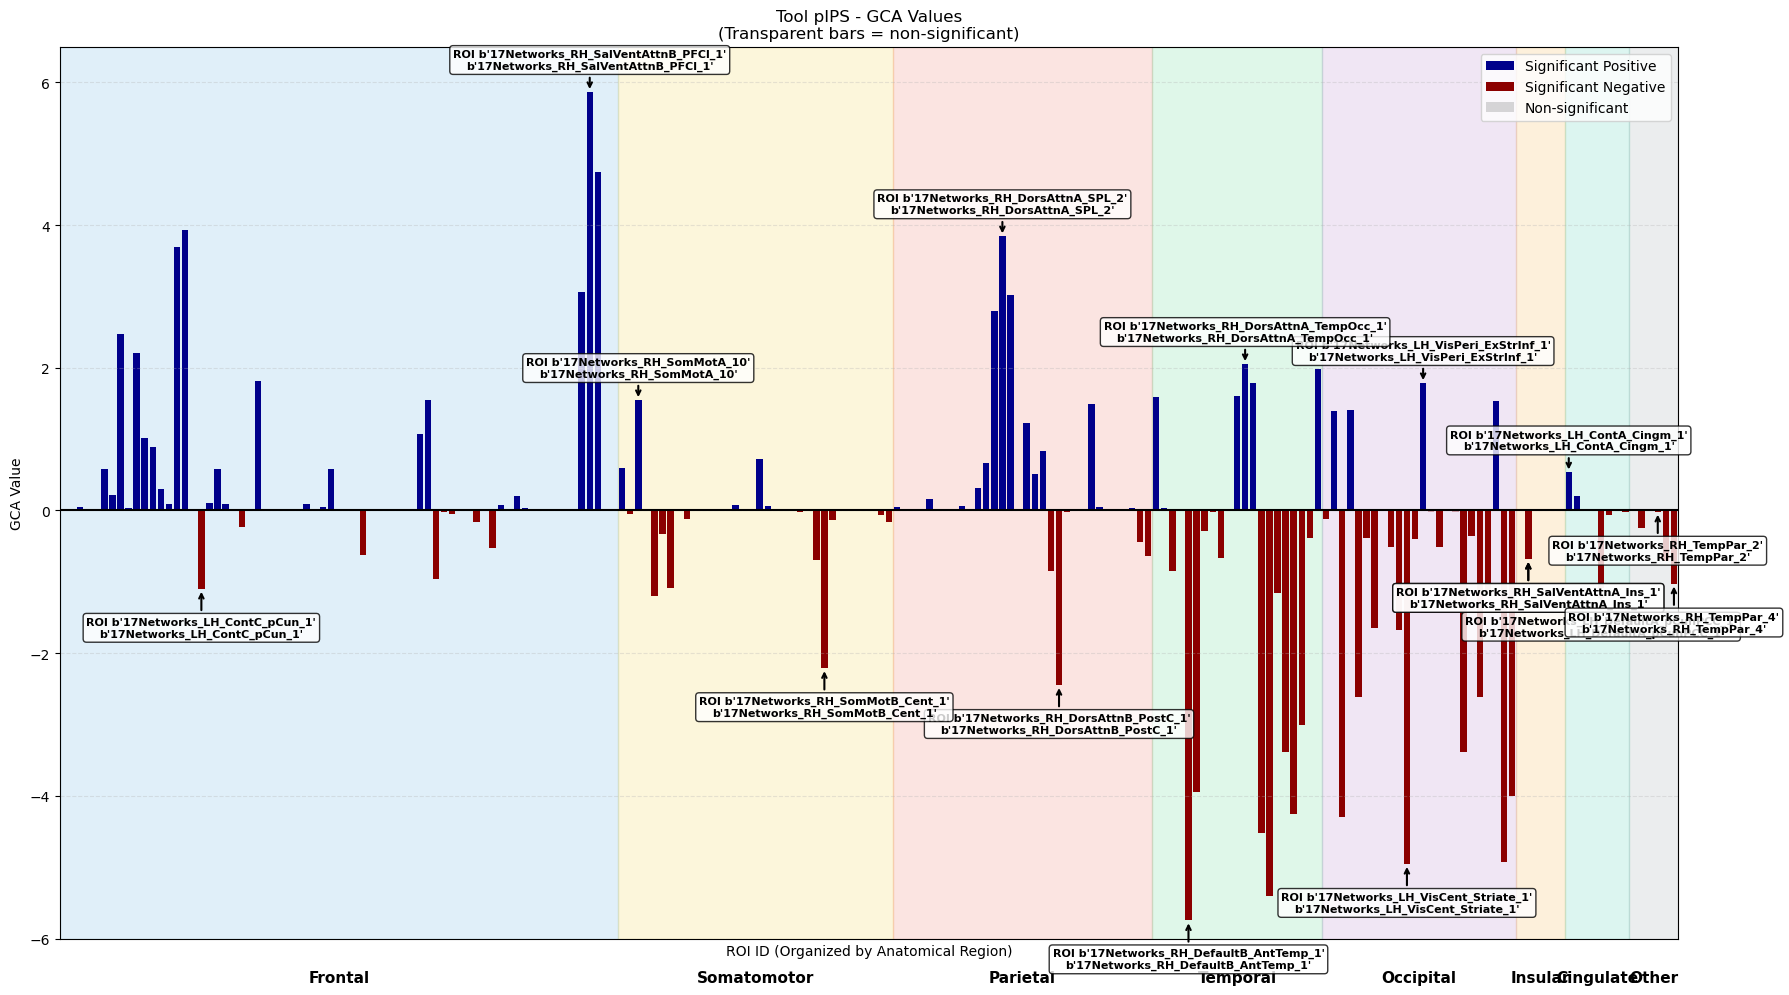

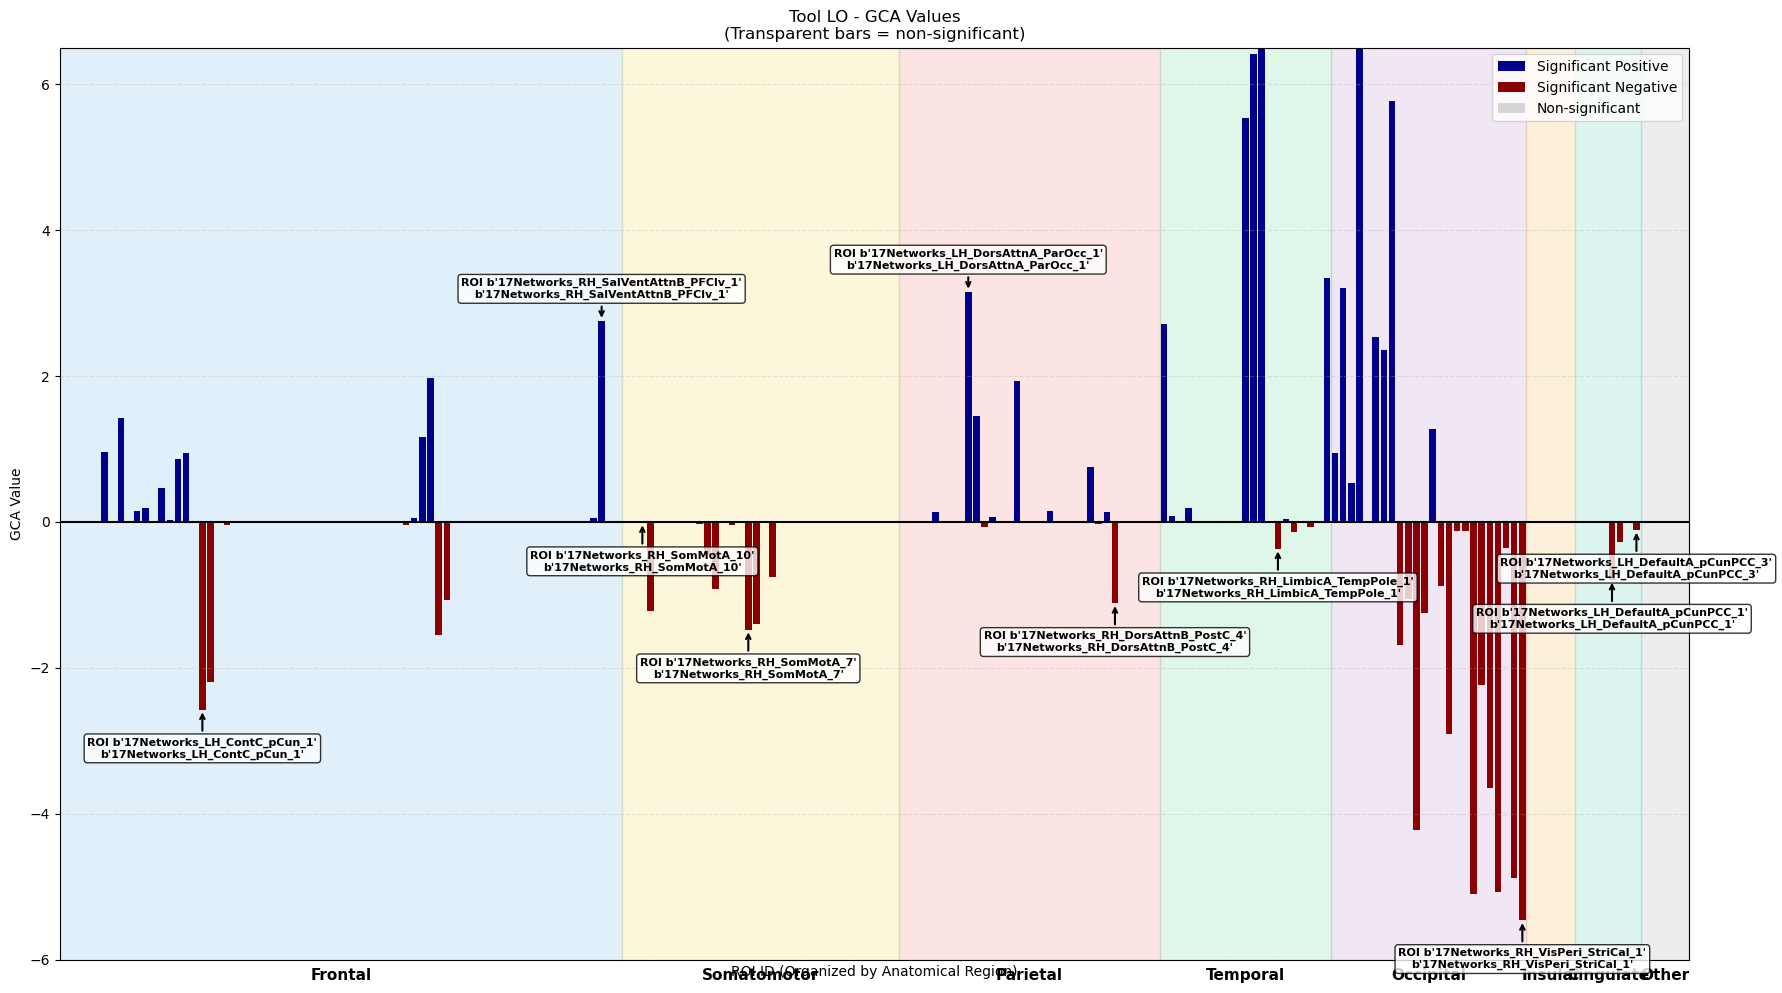

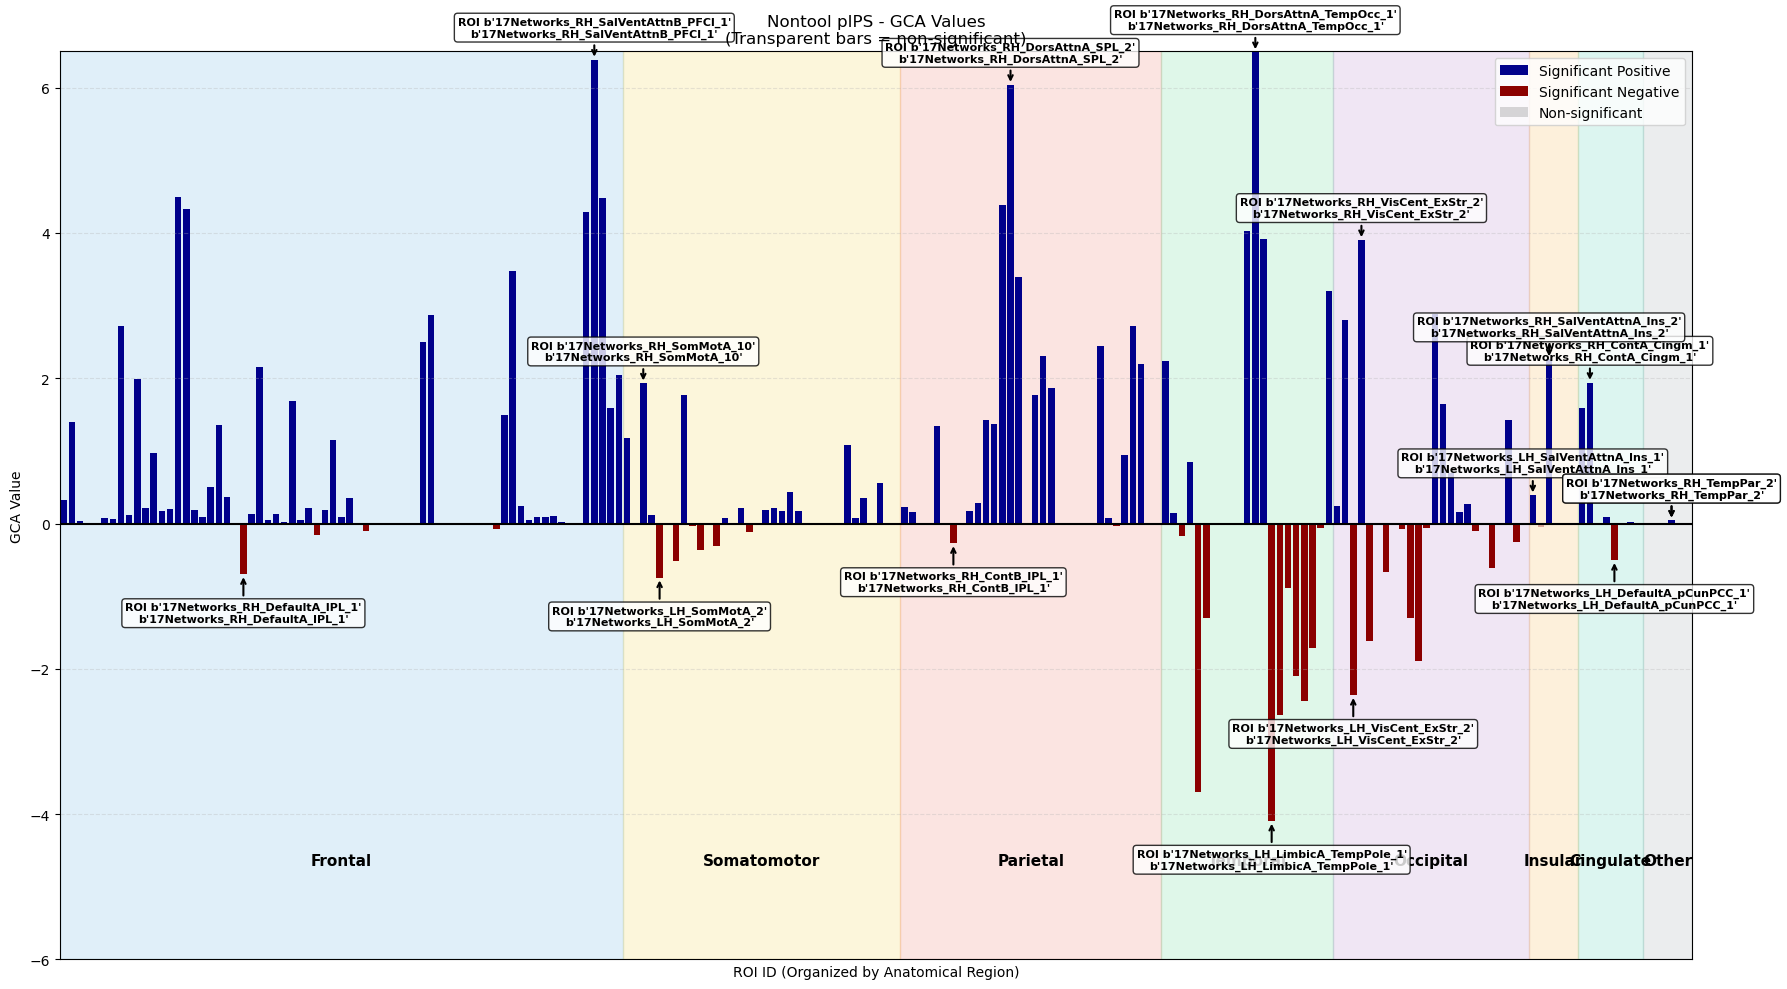

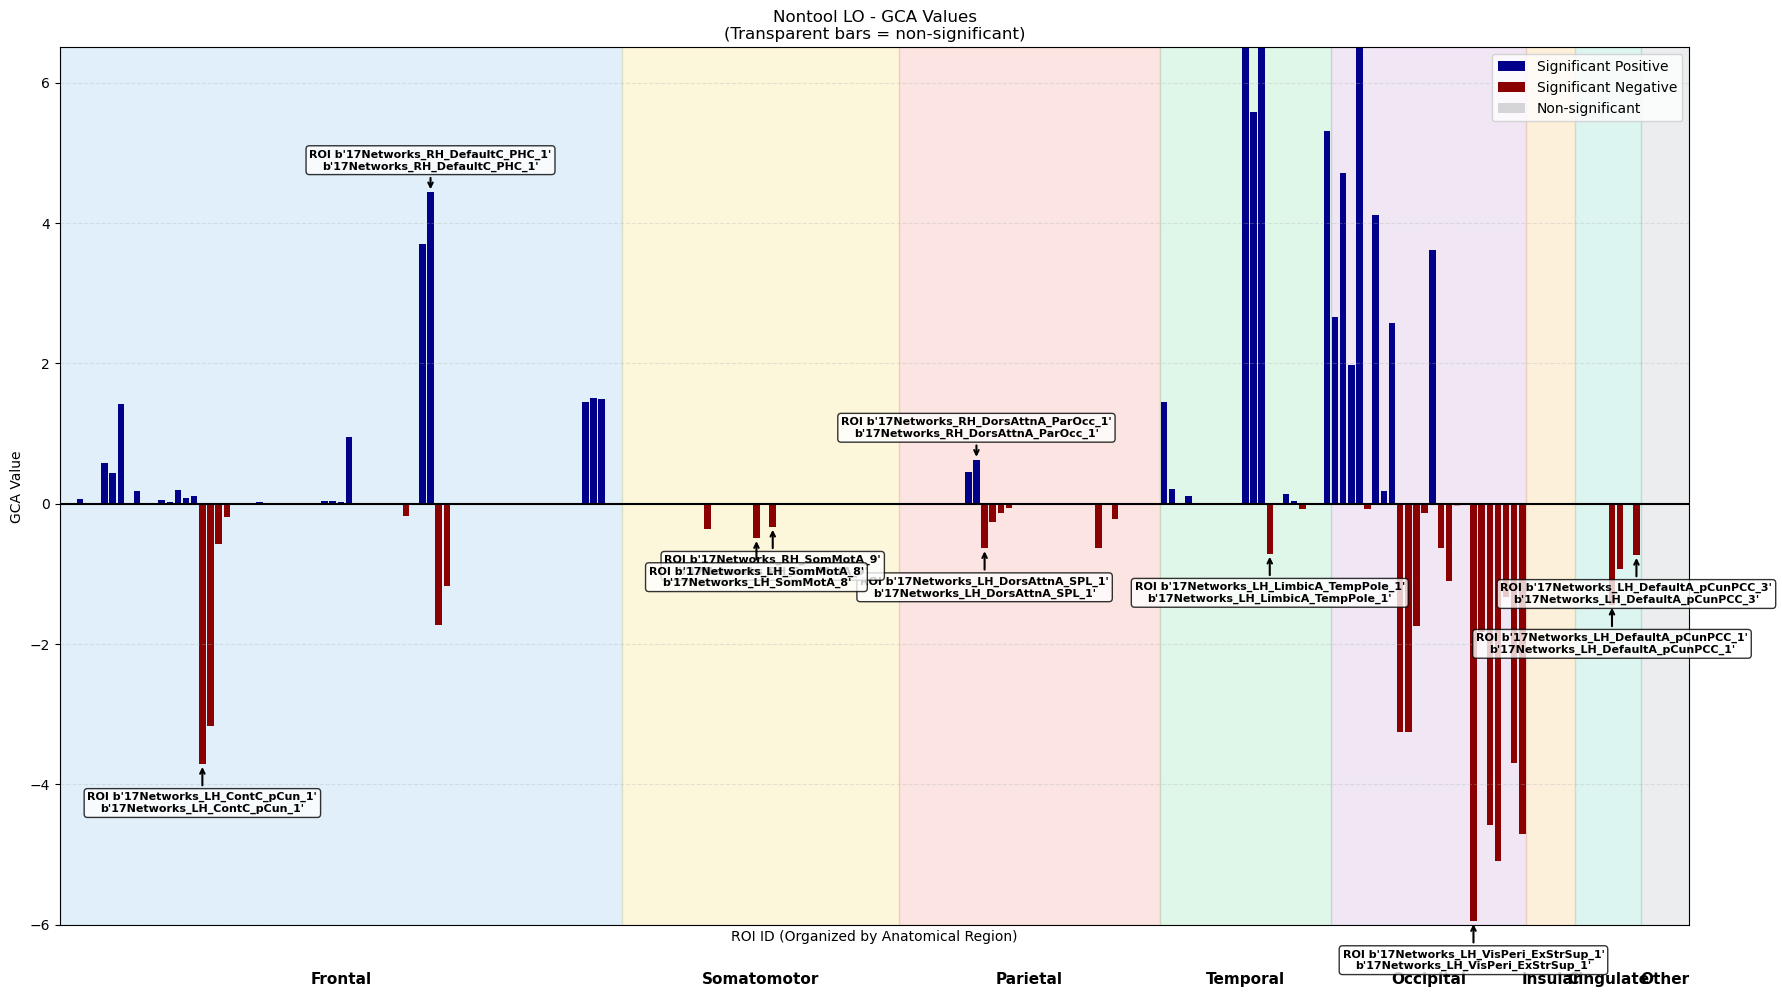

In [25]:
# Cell 4: Enhanced GCA bar plots with anatomical organization, LOOV, and bootstrapping
import re
import numpy as np
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars during bootstrapping

def plot_gca_anatomical_organization(roi_values, atlas_labels, output_dir, bootstrap_iterations=10):
    """Create anatomical organization visualization for GCA data with LOOV and bootstrapping"""
    print(f"\n{'='*80}")
    print(f"CREATING GCA ANATOMICAL ORGANIZATION VISUALIZATION - pIPS AND LO SEEDS")
    print(f"Using LOOV and Bootstrapping ({bootstrap_iterations} iterations)")
    print(f"{'='*80}")
    
    # Create output directory
    bar_plot_dir = os.path.join(output_dir, 'gca_anatomical')
    os.makedirs(bar_plot_dir, exist_ok=True)
    
    # Function to map ROI names to anatomical lobes (unchanged)
    def map_to_anatomical_lobe(roi_name):
        # Special handling for Wang atlas ROIs
        if 'Wang_pIPS' in roi_name:
            return 'Parietal'
        elif 'Wang_LO' in roi_name:
            return 'Temporal'
        
        # Map Schaefer networks to anatomical regions
        if 'Vis' in roi_name:
            return 'Occipital'
        elif 'SomMot' in roi_name:
            return 'Somatomotor'
        elif 'DorsAttn' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            else:
                return 'Parietal'
        elif 'SalVentAttn' in roi_name:
            if 'Ins' in roi_name:
                return 'Insular'
            elif 'Cing' in roi_name or 'ACC' in roi_name:
                return 'Cingulate'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'Par' in roi_name:
                return 'Parietal'
            else:
                return 'Frontal'
        elif 'Limbic' in roi_name:
            if 'Temp' in roi_name:
                return 'Temporal'
            else:
                return 'Frontal'
        elif 'Cont' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            elif 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        elif 'Default' in roi_name:
            if 'Par' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'PCC' in roi_name or 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        else:
            return 'Other'
    
    # Clean up ROI names for better labeling (unchanged)
    def clean_roi_name(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Handle Wang ROIs
        if 'Wang_' in roi_name:
            return roi_name.replace('Wang_', '')
        
        # Remove common prefixes and suffixes
        cleaned = roi_name.replace('7Networks_', '')
        
        # Extract just the region part, removing hemisphere and network
        parts = cleaned.split('_')
        if len(parts) > 2:
            return parts[-2] + '_' + parts[-1]
        elif len(parts) > 1:
            return parts[-1]
        else:
            return cleaned
    
    # Determine hemisphere and base region for organizing pairs (unchanged)
    def get_hemisphere_and_region(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Determine hemisphere 
        if 'LH' in roi_name:
            hemisphere = 'L'
        elif 'RH' in roi_name:
            hemisphere = 'R'
        else:
            # For Wang ROIs or ROIs without clear hemisphere
            if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
                hemisphere = 'X'  # Bilateral
            else:
                hemisphere = 'X'  # Unknown
        
        # Extract base region by removing hemisphere and number
        cleaned = roi_name.replace('7Networks_', '')
        cleaned = cleaned.replace('LH_', '').replace('RH_', '')
        
        # Handle Wang ROIs
        if 'Wang_' in cleaned:
            base_region = cleaned.replace('Wang_', '')
        else:
            # Remove trailing numbers which often differentiate regions
            base_region = re.sub(r'_\d+$', '', cleaned)
        
        return hemisphere, base_region
    
    # Perform bootstrapping on a set of values
    def bootstrap_analysis(values, n_iterations=10, confidence=0.95):
        if len(values) < 2:
            return np.nan, np.nan, np.nan
        
        # Initialize storage for bootstrap means
        bootstrap_means = np.zeros(n_iterations)
        
        # Perform bootstrap iterations
        for i in range(n_iterations):
            # Sample with replacement
            sample = np.random.choice(values, size=len(values), replace=True)
            bootstrap_means[i] = np.mean(sample)
        
        # Sort bootstrap means for confidence interval calculation
        bootstrap_means = np.sort(bootstrap_means)
        
        # Calculate confidence intervals
        lower_bound_idx = int((1 - confidence) / 2 * n_iterations)
        upper_bound_idx = int((1 - (1 - confidence) / 2) * n_iterations)
        
        # Return mean and CI
        return np.mean(values), bootstrap_means[lower_bound_idx], bootstrap_means[upper_bound_idx-1]
    
    # Perform Leave-One-Out Validation
    def loov_analysis(values):
        if len(values) < 2:
            return np.nan, np.nan
        
        # Storage for leave-one-out means
        loo_means = np.zeros(len(values))
        
        # Leave one out at a time
        for i in range(len(values)):
            # Create mask excluding current item
            mask = np.ones(len(values), dtype=bool)
            mask[i] = False
            
            # Calculate mean excluding current item
            loo_means[i] = np.mean(values[mask])
        
        # Return mean of LOO means and standard deviation
        return np.mean(loo_means), np.std(loo_means)
    
    # Filter and group data by condition and both pIPS and LO seeds
    print("Filtering for pIPS and LO seed ROIs and averaging left and right hemispheres...")
    
    # Group keys by condition and seed
    grouped_data = {}
    seed_keys = []
    
    # First, find all keys for pIPS and LO
    for img_key in roi_values.keys():
        condition, seed_roi, hemi = img_key.split('_')
        
        # Filter for pIPS and LO seeds
        if 'pIPS' in seed_roi or 'LO' in seed_roi:
            group_key = f"{condition}_{seed_roi}"
            if group_key not in grouped_data:
                grouped_data[group_key] = {'left': None, 'right': None}
            
            grouped_data[group_key][hemi] = img_key
            seed_keys.append(img_key)
    
    print(f"Found {len(seed_keys)} seed keys: {seed_keys}")
    
    # Create structure to store raw subject values for bootstrapping
    subject_values = {}
    
    # Now process each condition-seed group, averaging left and right hemispheres
    for group_key, hemi_keys in grouped_data.items():
        condition, seed_roi = group_key.split('_')
        
        # Skip if we don't have both hemispheres
        if hemi_keys['left'] is None or hemi_keys['right'] is None:
            print(f"Skipping {group_key} - missing one hemisphere")
            continue
        
        print(f"Processing {group_key} (averaging L and R hemispheres)...")
        
        # Collect and average data for all ROIs across both hemispheres
        combined_roi_data = {}
        subject_values[group_key] = {}
        
        # Process left hemisphere
        for roi_id in roi_values[hemi_keys['left']]:
            values_L = roi_values[hemi_keys['left']][roi_id]
            values_L = values_L[~np.isnan(values_L) & ~np.isinf(values_L)]
            
            if len(values_L) > 0:
                combined_roi_data[roi_id] = {'L': values_L, 'R': None}
                subject_values[group_key][roi_id] = []
        
        # Process right hemisphere
        for roi_id in roi_values[hemi_keys['right']]:
            values_R = roi_values[hemi_keys['right']][roi_id]
            values_R = values_R[~np.isnan(values_R) & ~np.isinf(values_R)]
            
            if len(values_R) > 0:
                if roi_id in combined_roi_data:
                    combined_roi_data[roi_id]['R'] = values_R
                else:
                    combined_roi_data[roi_id] = {'L': None, 'R': values_R}
                    subject_values[group_key][roi_id] = []
        
        # Create data for plotting
        roi_data = []
        
        # Average values for each ROI and perform statistics
        for roi_id, hemi_values in combined_roi_data.items():
            # Get ROI name
            if isinstance(roi_id, int):
                roi_name = atlas_labels[roi_id]
                if isinstance(roi_name, bytes):
                    roi_name = roi_name.decode('utf-8')
            else:
                # It's a Wang ROI
                roi_name = f"Wang_{roi_id}"
            
            # Combine L and R values if both exist
            if hemi_values['L'] is not None and hemi_values['R'] is not None:
                # Calculate the mean value for each subject by averaging L and R values
                if len(hemi_values['L']) == len(hemi_values['R']):
                    # If same number of samples, assume they are aligned
                    combined_values = (hemi_values['L'] + hemi_values['R']) / 2
                else:
                    # If different number of samples, concatenate
                    combined_values = np.concatenate([hemi_values['L'], hemi_values['R']])
            elif hemi_values['L'] is not None:
                combined_values = hemi_values['L']
            elif hemi_values['R'] is not None:
                combined_values = hemi_values['R']
            else:
                continue  # Skip if no values
            
            # Store combined values for bootstrapping
            subject_values[group_key][roi_id] = combined_values
            
            # Get basic statistics
            mean_value = np.mean(combined_values)
            
            # Perform t-test if possible
            if len(combined_values) > 1 and np.var(combined_values) > 0:
                t_stat, p_value = ttest_1samp(combined_values, 0)
                is_significant = p_value < 0.05
            else:
                t_stat, p_value = np.nan, np.nan
                is_significant = False
            
            # Perform LOOV analysis
            loov_mean, loov_std = loov_analysis(combined_values)
            
            # Perform bootstrap analysis
            print(f"  Running bootstrap for ROI {roi_id}...")
            bootstrap_mean, bootstrap_ci_lower, bootstrap_ci_upper = bootstrap_analysis(
                combined_values, n_iterations=bootstrap_iterations)
            
            # Add to data list
            roi_data.append({
                'ROI_ID': roi_id + 1 if isinstance(roi_id, int) else roi_id,  # Make 1-indexed for display
                'ROI_Name': roi_name,
                'Clean_Name': clean_roi_name(roi_name),
                'Mean_Value': mean_value,
                't_stat': t_stat,
                'p_value': p_value,
                'Significant': is_significant,
                'LOOV_Mean': loov_mean,
                'LOOV_Std': loov_std,
                'Bootstrap_Mean': bootstrap_mean,
                'Bootstrap_CI_Lower': bootstrap_ci_lower,
                'Bootstrap_CI_Upper': bootstrap_ci_upper
            })
        
        if not roi_data:
            print(f"No valid data for {group_key}, skipping")
            continue
        
        # Convert to DataFrame
        results_df = pd.DataFrame(roi_data)
        
        # Add anatomical lobe and hemisphere information
        results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
        
        # Extract hemisphere and base region info
        hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
        results_df['Hemisphere'] = [h for h, r in hemisphere_region]
        results_df['Base_Region'] = [r for h, r in hemisphere_region]
        
        # Define a manual order for anatomical lobes
        lobe_order = [
            'Frontal',
            'Somatomotor',
            'Parietal',
            'Temporal',
            'Occipital',
            'Insular',
            'Cingulate',
            'Other'
        ]
        
        # Create a category for sorting
        lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
        results_df['Lobe_Sorted'] = lobe_cat
        
        # Define colors for brain lobes (unchanged)
        lobe_colors = {
            'Frontal': '#3498db',     # Blue
            'Somatomotor': '#f1c40f', # Yellow
            'Parietal': '#e74c3c',    # Red
            'Temporal': '#2ecc71',    # Green
            'Occipital': '#9b59b6',   # Purple
            'Insular': '#f39c12',     # Orange
            'Cingulate': '#1abc9c',   # Turquoise
            'Other': '#7f8c8d'        # Gray
        }
        
        # Custom sorting function
        def custom_sort(row):
            lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
            hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
            return (lobe_idx, row['Base_Region'], hemi_idx)
        
        # Sort using the custom function
        results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
        results_df_sorted = results_df.sort_values('sort_key')
        
        # Get the new order
        sorted_indices = results_df_sorted.index.values
        
        # Extract reordered data
        mean_values_sorted = results_df_sorted['Mean_Value'].values
        sig_sorted = results_df_sorted['Significant'].values
        roi_ids_sorted = results_df_sorted['ROI_ID'].values
        
        # Get bootstrap confidence intervals (for reporting, not plotting)
        bootstrap_ci_lower_sorted = results_df_sorted['Bootstrap_CI_Lower'].values
        bootstrap_ci_upper_sorted = results_df_sorted['Bootstrap_CI_Upper'].values
        
        # Find peak (highest) and bottom (lowest) significant ROI in each lobe
        significant_peak_bottom_indices = []
        lobe_groups = results_df_sorted.groupby('Anatomical_Lobe')
        
        for lobe, group in lobe_groups:
            if len(group) > 0:
                # Get significant ROIs in this lobe
                sig_group = group[group['Significant']]
                
                if len(sig_group) > 0:
                    # Get highest value (most positive) significant ROI
                    peak_idx = sig_group['Mean_Value'].idxmax()
                    significant_peak_bottom_indices.append(peak_idx)
                    
                    # Get lowest value (most negative) significant ROI
                    bottom_idx = sig_group['Mean_Value'].idxmin()
                    significant_peak_bottom_indices.append(bottom_idx)
        
        # Create the visualization (without bootstrap error bars)
        plt.figure(figsize=(18, 10))

        # Define x positions
        x = np.arange(len(mean_values_sorted))

        # Plot background colors for different lobes
        current_lobe = None
        start_idx = 0
        min_val = min(mean_values_sorted) * 1.15  # Position for bottom labels

        for i, idx in enumerate(sorted_indices):
            lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
            if lobe != current_lobe:
                if current_lobe is not None:
                    # Mark the region for the previous lobe
                    plt.axvspan(start_idx - 0.5, i - 0.5, alpha=0.15, 
                            color=lobe_colors[current_lobe])
                    # Add label in the middle of the region at the bottom
                    plt.text((start_idx + i - 1) / 2, min_val, 
                            current_lobe, ha='center', fontsize=11, fontweight='bold')
                current_lobe = lobe
                start_idx = i

        # Add the last region with label at bottom
        plt.axvspan(start_idx - 0.5, len(mean_values_sorted) - 0.5, alpha=0.15, 
                color=lobe_colors[current_lobe])
        plt.text((start_idx + len(mean_values_sorted) - 1) / 2, min_val, 
                current_lobe, ha='center', fontsize=11, fontweight='bold')

        # Create base bar plot with colors based on positive/negative values
        base_colors = ['darkblue' if val > 0 else 'darkred' for val in mean_values_sorted]
        bars = plt.bar(x, mean_values_sorted, color=base_colors)

        # Apply transparency to non-significant bars
        for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
            if not is_sig:
                # Set alpha for non-significant bars only
                bar.set_alpha(0.3)

        plt.axhline(y=0, color='black', linestyle='-')

        # Add a legend for significance
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='darkblue', alpha=1.0, label='Significant Positive'),
            Patch(facecolor='darkred', alpha=1.0, label='Significant Negative'),
            Patch(facecolor='gray', alpha=0.3, label='Non-significant')
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        # Label significant peak and bottom ROIs
        for peak_idx in significant_peak_bottom_indices:
            # Find position in sorted array
            position = np.where(sorted_indices == peak_idx)[0][0]
            roi_id = results_df.loc[peak_idx, 'ROI_ID']
            roi_name = results_df.loc[peak_idx, 'Clean_Name']
            mean_value = results_df.loc[peak_idx, 'Mean_Value']
            
            # Add annotation
            plt.annotate(f'ROI {roi_id}\n{roi_name}',
                        xy=(position, mean_value),
                        xytext=(0, 15 if mean_value >= 0 else -20),
                        textcoords='offset points',
                        ha='center',
                        va='bottom' if mean_value >= 0 else 'top',
                        fontsize=8,
                        fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

        # Set labels
        plt.ylabel('GCA Value')
        plt.xlabel('ROI ID (Organized by Anatomical Region)')
        # Note: removed mention of bootstrap CI from title since not shown in plot
        plt.title(f'{condition.capitalize()} {seed_roi} - GCA Values\n(Transparent bars = non-significant)')
        plt.xlim(-0.5, len(mean_values_sorted) - 0.5)
        # Set y-axis limits to fixed value of 6
        plt.ylim(-6, 6.5)
        # Remove x-axis tick labels
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        # Add grid for readability
        plt.grid(axis='y', linestyle='--', alpha=0.3)

        # Adjust layout
        plt.tight_layout()

        # Save figure
        fig_path = f'{bar_plot_dir}/{condition}_{seed_roi}_gca_anatomical.png'
        plt.savefig(fig_path, dpi=300)
        #plt.close()
        
        print(f"Figure saved to {fig_path}")
        
        # Save results table with all statistical metrics
        results_file = f'{bar_plot_dir}/{condition}_{seed_roi}_gca_statistics.csv'
        results_df_sorted.to_csv(results_file, index=False)
        print(f"Statistics saved to {results_file}")
        
        # Print peak and bottom ROIs by lobe, only for significant ROIs
        print(f"\nGCA significant peak and bottom ROIs by anatomical lobe:")
        for lobe, group in lobe_groups:
            # Get significant ROIs in this lobe
            sig_group = group[group['Significant']]
            
            if len(sig_group) > 0:
                print(f"\n{lobe} Lobe:")
                
                # Peak (positive) significant ROI
                peak_row = sig_group.loc[sig_group['Mean_Value'].idxmax()]
                print(f"  Peak (Positive): ROI {peak_row['ROI_ID']} ({peak_row['Clean_Name']})")
                print(f"    Value = {peak_row['Mean_Value']:.3f}")
                print(f"    Bootstrap 95% CI: [{peak_row['Bootstrap_CI_Lower']:.3f}, {peak_row['Bootstrap_CI_Upper']:.3f}]")
                print(f"    LOOV: {peak_row['LOOV_Mean']:.3f} ± {peak_row['LOOV_Std']:.3f}")
                
                # Bottom (negative) significant ROI
                bottom_row = sig_group.loc[sig_group['Mean_Value'].idxmin()]
                print(f"  Bottom (Negative): ROI {bottom_row['ROI_ID']} ({bottom_row['Clean_Name']})")
                print(f"    Value = {bottom_row['Mean_Value']:.3f}")
                print(f"    Bootstrap 95% CI: [{bottom_row['Bootstrap_CI_Lower']:.3f}, {bottom_row['Bootstrap_CI_Upper']:.3f}]")
                print(f"    LOOV: {bottom_row['LOOV_Mean']:.3f} ± {bottom_row['LOOV_Std']:.3f}")
                
plot_gca_anatomical_organization(roi_values, atlas_labels, output_dir, bootstrap_iterations=10)

In [28]:
def plot_gca_anatomical_organization(roi_values, atlas_labels, output_dir, bootstrap_iterations=10):
    """Create anatomical organization visualization for GCA data with LOOV and bootstrapping"""
    print(f"\n{'='*80}")
    print(f"CREATING GCA ANATOMICAL ORGANIZATION VISUALIZATION - pIPS AND LO SEEDS")
    print(f"Using LOOV and Bootstrapping ({bootstrap_iterations} iterations)")
    print(f"{'='*80}")
    
    # Create output directory
    bar_plot_dir = os.path.join(output_dir, 'gca_anatomical')
    os.makedirs(bar_plot_dir, exist_ok=True)
    
    # Function to map ROI names to anatomical lobes
    def map_to_anatomical_lobe(roi_name):
        # Special handling for Wang atlas ROIs
        if 'Wang_pIPS' in roi_name:
            return 'Parietal'
        elif 'Wang_LO' in roi_name:
            return 'Temporal'
        
        # Map Schaefer networks to anatomical regions
        if 'Vis' in roi_name:
            return 'Occipital'
        elif 'SomMot' in roi_name:
            return 'Somatomotor'
        elif 'DorsAttn' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            else:
                return 'Parietal'
        elif 'SalVentAttn' in roi_name:
            if 'Ins' in roi_name:
                return 'Insular'
            elif 'Cing' in roi_name or 'ACC' in roi_name:
                return 'Cingulate'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'Par' in roi_name:
                return 'Parietal'
            else:
                return 'Frontal'
        elif 'Limbic' in roi_name:
            if 'Temp' in roi_name:
                return 'Temporal'
            else:
                return 'Frontal'
        elif 'Cont' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            elif 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        elif 'Default' in roi_name:
            if 'Par' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'PCC' in roi_name or 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        else:
            return 'Other'
    
    # Clean up ROI names for better labeling
    def clean_roi_name(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Handle Wang ROIs
        if 'Wang_' in roi_name:
            return roi_name.replace('Wang_', '')
        
        # Remove common prefixes and suffixes
        cleaned = roi_name.replace('7Networks_', '')
        
        # Extract just the region part, removing hemisphere and network
        parts = cleaned.split('_')
        if len(parts) > 2:
            return parts[-2] + '_' + parts[-1]
        elif len(parts) > 1:
            return parts[-1]
        else:
            return cleaned
    
    # Determine hemisphere and base region for organizing pairs
    def get_hemisphere_and_region(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Determine hemisphere 
        if 'LH' in roi_name:
            hemisphere = 'L'
        elif 'RH' in roi_name:
            hemisphere = 'R'
        else:
            # For Wang ROIs or ROIs without clear hemisphere
            if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
                hemisphere = 'X'  # Bilateral
            else:
                hemisphere = 'X'  # Unknown
        
        # Extract base region by removing hemisphere and number
        cleaned = roi_name.replace('7Networks_', '')
        cleaned = cleaned.replace('LH_', '').replace('RH_', '')
        
        # Handle Wang ROIs
        if 'Wang_' in cleaned:
            base_region = cleaned.replace('Wang_', '')
        else:
            # Remove trailing numbers which often differentiate regions
            base_region = re.sub(r'_\d+$', '', cleaned)
        
        return hemisphere, base_region
    
    # Perform bootstrapping on a set of values
    def bootstrap_analysis(values, n_iterations=10, confidence=0.95):
        if len(values) < 2:
            return np.nan, np.nan, np.nan
        
        # Initialize storage for bootstrap means
        bootstrap_means = np.zeros(n_iterations)
        
        # Perform bootstrap iterations
        for i in range(n_iterations):
            # Sample with replacement
            sample = np.random.choice(values, size=len(values), replace=True)
            bootstrap_means[i] = np.mean(sample)
        
        # Sort bootstrap means for confidence interval calculation
        bootstrap_means = np.sort(bootstrap_means)
        
        # Calculate confidence intervals
        lower_bound_idx = int((1 - confidence) / 2 * n_iterations)
        upper_bound_idx = int((1 - (1 - confidence) / 2) * n_iterations)
        
        # Return mean and CI
        return np.mean(values), bootstrap_means[lower_bound_idx], bootstrap_means[upper_bound_idx-1]
    
    # Perform Leave-One-Out Validation
    def loov_analysis(values):
        if len(values) < 2:
            return np.nan, np.nan
        
        # Storage for leave-one-out means
        loo_means = np.zeros(len(values))
        
        # Leave one out at a time
        for i in range(len(values)):
            # Create mask excluding current item
            mask = np.ones(len(values), dtype=bool)
            mask[i] = False
            
            # Calculate mean excluding current item
            loo_means[i] = np.mean(values[mask])
        
        # Return mean of LOO means and standard deviation
        return np.mean(loo_means), np.std(loo_means)
    
    # Filter and group data by condition and both pIPS and LO seeds
    print("Filtering for pIPS and LO seed ROIs and averaging left and right hemispheres...")
    
    # Group keys by condition and seed
    grouped_data = {}
    seed_keys = []
    
    # First, find all keys for pIPS and LO
    for img_key in roi_values.keys():
        condition, seed_roi, hemi = img_key.split('_')
        
        # Filter for pIPS and LO seeds
        if 'pIPS' in seed_roi or 'LO' in seed_roi:
            group_key = f"{condition}_{seed_roi}"
            if group_key not in grouped_data:
                grouped_data[group_key] = {'left': None, 'right': None}
            
            grouped_data[group_key][hemi] = img_key
            seed_keys.append(img_key)
    
    print(f"Found {len(seed_keys)} seed keys: {seed_keys}")
    
    # Create structure to store raw subject values for bootstrapping
    subject_values = {}
    
    # Now process each condition-seed group, averaging left and right hemispheres
    for group_key, hemi_keys in grouped_data.items():
        condition, seed_roi = group_key.split('_')
        
        # Skip if we don't have both hemispheres
        if hemi_keys['left'] is None or hemi_keys['right'] is None:
            print(f"Skipping {group_key} - missing one hemisphere")
            continue
        
        print(f"Processing {group_key} (averaging L and R hemispheres)...")
        
        # Collect and average data for all ROIs across both hemispheres
        combined_roi_data = {}
        subject_values[group_key] = {}
        
        # Process left hemisphere
        for roi_id in roi_values[hemi_keys['left']]:
            values_L = roi_values[hemi_keys['left']][roi_id]
            values_L = values_L[~np.isnan(values_L) & ~np.isinf(values_L)]
            
            if len(values_L) > 0:
                combined_roi_data[roi_id] = {'L': values_L, 'R': None}
                subject_values[group_key][roi_id] = []
        
        # Process right hemisphere
        for roi_id in roi_values[hemi_keys['right']]:
            values_R = roi_values[hemi_keys['right']][roi_id]
            values_R = values_R[~np.isnan(values_R) & ~np.isinf(values_R)]
            
            if len(values_R) > 0:
                if roi_id in combined_roi_data:
                    combined_roi_data[roi_id]['R'] = values_R
                else:
                    combined_roi_data[roi_id] = {'L': None, 'R': values_R}
                    subject_values[group_key][roi_id] = []
        
        # Create data for plotting
        roi_data = []
        
        # Average values for each ROI and perform statistics
        for roi_id, hemi_values in combined_roi_data.items():
            # Get ROI name
            if isinstance(roi_id, int):
                roi_name = atlas_labels[roi_id]
                if isinstance(roi_name, bytes):
                    roi_name = roi_name.decode('utf-8')
            else:
                # It's a Wang ROI
                roi_name = f"Wang_{roi_id}"
            
            # Combine L and R values if both exist
            if hemi_values['L'] is not None and hemi_values['R'] is not None:
                # Calculate the mean value for each subject by averaging L and R values
                if len(hemi_values['L']) == len(hemi_values['R']):
                    # If same number of samples, assume they are aligned
                    combined_values = (hemi_values['L'] + hemi_values['R']) / 2
                else:
                    # If different number of samples, concatenate
                    combined_values = np.concatenate([hemi_values['L'], hemi_values['R']])
            elif hemi_values['L'] is not None:
                combined_values = hemi_values['L']
            elif hemi_values['R'] is not None:
                combined_values = hemi_values['R']
            else:
                continue  # Skip if no values
            
            # Store combined values for bootstrapping
            subject_values[group_key][roi_id] = combined_values
            
            # Get basic statistics
            mean_value = np.mean(combined_values)
            
            # Perform t-test if possible
            if len(combined_values) > 1 and np.var(combined_values) > 0:
                t_stat, p_value = ttest_1samp(combined_values, 0)
                is_significant = p_value < 0.05
            else:
                t_stat, p_value = np.nan, np.nan
                is_significant = False
            
            # Perform LOOV analysis
            loov_mean, loov_std = loov_analysis(combined_values)
            
            # Perform bootstrap analysis
            print(f"  Running bootstrap for ROI {roi_id}...")
            bootstrap_mean, bootstrap_ci_lower, bootstrap_ci_upper = bootstrap_analysis(
                combined_values, n_iterations=bootstrap_iterations)
            
            # Add to data list
            roi_data.append({
                'ROI_ID': roi_id + 1 if isinstance(roi_id, int) else roi_id,  # Make 1-indexed for display
                'ROI_Name': roi_name,
                'Clean_Name': clean_roi_name(roi_name),
                'Mean_Value': mean_value,
                't_stat': t_stat,
                'p_value': p_value,
                'Significant': is_significant,
                'LOOV_Mean': loov_mean,
                'LOOV_Std': loov_std,
                'Bootstrap_Mean': bootstrap_mean,
                'Bootstrap_CI_Lower': bootstrap_ci_lower,
                'Bootstrap_CI_Upper': bootstrap_ci_upper
            })
        
        if not roi_data:
            print(f"No valid data for {group_key}, skipping")
            continue
        
        # Convert to DataFrame
        results_df = pd.DataFrame(roi_data)
        
        # Add anatomical lobe and hemisphere information
        results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
        
        # Extract hemisphere and base region info
        hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
        results_df['Hemisphere'] = [h for h, r in hemisphere_region]
        results_df['Base_Region'] = [r for h, r in hemisphere_region]
        
        # Define a manual order for anatomical lobes
        lobe_order = [
            'Frontal',
            'Somatomotor',
            'Parietal',
            'Temporal',
            'Occipital',
            'Insular',
            'Cingulate',
            'Other'
        ]
        
        # Create a category for sorting
        lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
        results_df['Lobe_Sorted'] = lobe_cat
        
        # Custom sorting function
        def custom_sort(row):
            lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
            hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
            return (lobe_idx, row['Base_Region'], hemi_idx)
        
        # Sort using the custom function
        results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
        results_df_sorted = results_df.sort_values('sort_key')
        
        # Get the new order
        sorted_indices = results_df_sorted.index.values
        
        # Extract reordered data
        mean_values_sorted = results_df_sorted['Mean_Value'].values
        sig_sorted = results_df_sorted['Significant'].values
        roi_ids_sorted = results_df_sorted['ROI_ID'].values
        
        # Get bootstrap confidence intervals (for reporting, not plotting)
        bootstrap_ci_lower_sorted = results_df_sorted['Bootstrap_CI_Lower'].values
        bootstrap_ci_upper_sorted = results_df_sorted['Bootstrap_CI_Upper'].values
        
        # Find peak (highest) and bottom (lowest) significant ROI in each lobe
        significant_peak_bottom_indices = []
        lobe_groups = results_df_sorted.groupby('Anatomical_Lobe')
        
        for lobe, group in lobe_groups:
            if len(group) > 0:
                # Get significant ROIs in this lobe
                sig_group = group[group['Significant']]
                
                if len(sig_group) > 0:
                    # Get highest value (most positive) significant ROI
                    peak_idx = sig_group['Mean_Value'].idxmax()
                    significant_peak_bottom_indices.append(peak_idx)
                    
                    # Get lowest value (most negative) significant ROI
                    bottom_idx = sig_group['Mean_Value'].idxmin()
                    significant_peak_bottom_indices.append(bottom_idx)
        
        
                # Create the visualization (UPDATED VERSION)
                
        # Create the visualization (FINAL VERSION)
        plt.figure(figsize=(18, 10))

        # Define x positions
        x = np.arange(len(mean_values_sorted))

        # Create base bar plot with colors (positive=red, negative=blue)
        base_colors = ['red' if val > 0 else 'blue' for val in mean_values_sorted]
        bars = plt.bar(x, mean_values_sorted, color=base_colors)

        # Apply transparency to non-significant bars
        for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
            if not is_sig:
                bar.set_alpha(0.3)

        plt.axhline(y=0, color='black', linestyle='-')

        # Add vertical lines to demarcate lobe boundaries
        current_lobe = None
        start_idx = 0
        min_val = min(mean_values_sorted) * 1.15  # Position for bottom labels
        y_max = max(mean_values_sorted) * 1.05

        for i, idx in enumerate(sorted_indices):
            lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
            if lobe != current_lobe:
                if current_lobe is not None:
                    # Add vertical line at lobe boundary
                    plt.axvline(i - 0.5, color='gray', linestyle='--', alpha=0.5)
                    # Add label in the middle of the region at the bottom
                    plt.text((start_idx + i - 1) / 2, min_val, 
                            current_lobe, ha='center', fontsize=11, fontweight='bold')
                current_lobe = lobe
                start_idx = i

        # Add the last vertical line and lobe label
        plt.axvline(len(mean_values_sorted) - 0.5, color='gray', linestyle='--', alpha=0.5)
        plt.text((start_idx + len(mean_values_sorted) - 1) / 2, min_val, 
                current_lobe, ha='center', fontsize=11, fontweight='bold')

        # Add a legend for significance
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', alpha=1.0, label='Significant Positive'),
            Patch(facecolor='blue', alpha=1.0, label='Significant Negative'),
            Patch(facecolor='gray', alpha=0.3, label='Non-significant')
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        # Label significant peak and bottom ROIs
        for peak_idx in significant_peak_bottom_indices:
            position = np.where(sorted_indices == peak_idx)[0][0]
            roi_id = results_df.loc[peak_idx, 'ROI_ID']
            roi_name = results_df.loc[peak_idx, 'Clean_Name']
            mean_value = results_df.loc[peak_idx, 'Mean_Value']
            
            plt.annotate(f'ROI {roi_id}\n{roi_name}',
                        xy=(position, mean_value),
                        xytext=(0, 15 if mean_value >= 0 else -20),
                        textcoords='offset points',
                        ha='center',
                        va='bottom' if mean_value >= 0 else 'top',
                        fontsize=8,
                        fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

        # Set labels and remove x-axis ticks completely
        plt.ylabel('GCA Value')
        plt.xlabel('')
        plt.title(f'{condition.capitalize()} {seed_roi} - GCA Values\n(Transparent bars = non-significant)')
        plt.xlim(-0.5, len(mean_values_sorted) - 0.5)
        plt.ylim(-6, 6.5)
        plt.xticks([])  # This completely removes x-axis ticks and labels

        # Add grid for readability (only horizontal)
        plt.grid(axis='y', linestyle='--', alpha=0.3)

        plt.tight_layout()


        # Label significant peak and bottom ROIs
        for peak_idx in significant_peak_bottom_indices:
            # Find position in sorted array
            position = np.where(sorted_indices == peak_idx)[0][0]
            roi_id = results_df.loc[peak_idx, 'ROI_ID']
            roi_name = results_df.loc[peak_idx, 'Clean_Name']
            mean_value = results_df.loc[peak_idx, 'Mean_Value']
            
            # Add annotation
            plt.annotate(f'ROI {roi_id}\n{roi_name}',
                        xy=(position, mean_value),
                        xytext=(0, 15 if mean_value >= 0 else -20),
                        textcoords='offset points',
                        ha='center',
                        va='bottom' if mean_value >= 0 else 'top',
                        fontsize=8,
                        fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                        arrowprops=dict(arrowstyle='->', lw=1.5))

        # Set labels
        plt.ylabel('GCA Value')
        plt.xlabel('ROI ID (Organized by Anatomical Region)')
        plt.title(f'{condition.capitalize()} {seed_roi} - GCA Values\n(Transparent bars = non-significant)')
        plt.xlim(-0.5, len(mean_values_sorted) - 0.5)
        plt.ylim(-6, 6.5)
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        # Add grid for readability
        plt.grid(axis='y', linestyle='--', alpha=0.3)

        # Adjust layout
        plt.tight_layout()

        # Save figure
        fig_path = f'{bar_plot_dir}/{condition}_{seed_roi}_gca_anatomical.png'
        plt.savefig(fig_path, dpi=300)
        plt.close()
        
        print(f"Figure saved to {fig_path}")
        
        # Save results table with all statistical metrics
        results_file = f'{bar_plot_dir}/{condition}_{seed_roi}_gca_statistics.csv'
        results_df_sorted.to_csv(results_file, index=False)
        print(f"Statistics saved to {results_file}")
        
        # Print peak and bottom ROIs by lobe, only for significant ROIs
        print(f"\nGCA significant peak and bottom ROIs by anatomical lobe:")
        for lobe, group in lobe_groups:
            # Get significant ROIs in this lobe
            sig_group = group[group['Significant']]
            
            if len(sig_group) > 0:
                print(f"\n{lobe} Lobe:")
                
                # Peak (positive) significant ROI
                peak_row = sig_group.loc[sig_group['Mean_Value'].idxmax()]
                print(f"  Peak (Positive): ROI {peak_row['ROI_ID']} ({peak_row['Clean_Name']})")
                print(f"    Value = {peak_row['Mean_Value']:.3f}")
                print(f"    Bootstrap 95% CI: [{peak_row['Bootstrap_CI_Lower']:.3f}, {peak_row['Bootstrap_CI_Upper']:.3f}]")
                print(f"    LOOV: {peak_row['LOOV_Mean']:.3f} ± {peak_row['LOOV_Std']:.3f}")
                
                # Bottom (negative) significant ROI
                bottom_row = sig_group.loc[sig_group['Mean_Value'].idxmin()]
                print(f"  Bottom (Negative): ROI {bottom_row['ROI_ID']} ({bottom_row['Clean_Name']})")
                print(f"    Value = {bottom_row['Mean_Value']:.3f}")
                print(f"    Bootstrap 95% CI: [{bottom_row['Bootstrap_CI_Lower']:.3f}, {bottom_row['Bootstrap_CI_Upper']:.3f}]")
                print(f"    LOOV: {bottom_row['LOOV_Mean']:.3f} ± {bottom_row['LOOV_Std']:.3f}")
                
plot_gca_anatomical_organization(roi_values, atlas_labels, output_dir, bootstrap_iterations=10)


CREATING GCA ANATOMICAL ORGANIZATION VISUALIZATION - pIPS AND LO SEEDS
Using LOOV and Bootstrapping (10 iterations)
Filtering for pIPS and LO seed ROIs and averaging left and right hemispheres...
Found 8 seed keys: ['tool_pIPS_left', 'tool_pIPS_right', 'tool_LO_left', 'tool_LO_right', 'nontool_pIPS_left', 'nontool_pIPS_right', 'nontool_LO_left', 'nontool_LO_right']
Processing tool_pIPS (averaging L and R hemispheres)...
  Running bootstrap for ROI b'17Networks_LH_VisCent_ExStr_1'...
  Running bootstrap for ROI b'17Networks_LH_VisCent_ExStr_2'...
  Running bootstrap for ROI b'17Networks_LH_VisCent_Striate_1'...
  Running bootstrap for ROI b'17Networks_LH_VisCent_ExStr_3'...
  Running bootstrap for ROI b'17Networks_LH_VisCent_ExStr_4'...
  Running bootstrap for ROI b'17Networks_LH_VisCent_ExStr_5'...
  Running bootstrap for ROI b'17Networks_LH_VisPeri_ExStrInf_1'...
  Running bootstrap for ROI b'17Networks_LH_VisPeri_ExStrInf_2'...
  Running bootstrap for ROI b'17Networks_LH_VisPeri_ExS

In [37]:
def print_gca_differences(roi_values):
    """Simple ROI-by-ROI difference printing"""
    print("\nTOOL vs NONTOOL DIFFERENCES (Tool - NonTool)")
    print("ROI_ID\tDifference")
    
    # Find tool and nontool conditions (assuming same ROIs exist in both)
    tool_key = [k for k in roi_values.keys() if 'tool' in k][0]
    nontool_key = [k for k in roi_values.keys() if 'nontool' in k][0]
    
    # Get ROI IDs (sorted)
    roi_ids = sorted(roi_values[tool_key].keys())
    
    # Print differences
    for roi_id in roi_ids:
        tool_mean = np.nanmean(roi_values[tool_key][roi_id])
        nontool_mean = np.nanmean(roi_values[nontool_key][roi_id])
        diff = tool_mean - nontool_mean
        print(f"{roi_id}\t{diff:.4f}")

# Example usage:
print_gca_differences(roi_values)


TOOL vs NONTOOL DIFFERENCES (Tool - NonTool)
ROI_ID	Difference
b'17Networks_LH_ContA_Cingm_1'	-1.9657
b'17Networks_LH_ContA_IPS_1'	-0.2807
b'17Networks_LH_ContA_IPS_2'	0.0000
b'17Networks_LH_ContA_IPS_3'	-0.0462
b'17Networks_LH_ContA_PFCd_1'	-0.4673
b'17Networks_LH_ContA_PFCl_1'	0.0083
b'17Networks_LH_ContA_PFCl_2'	0.0000
b'17Networks_LH_ContA_PFCl_3'	-0.0172
b'17Networks_LH_ContA_PFClv_1'	0.0644
b'17Networks_LH_ContA_Temp_1'	-2.7512
b'17Networks_LH_ContB_IPL_1'	0.0000
b'17Networks_LH_ContB_PFCl_1'	-0.1672
b'17Networks_LH_ContB_PFClv_1'	0.4231
b'17Networks_LH_ContB_PFClv_2'	0.2455
b'17Networks_LH_ContB_Temp_1'	-0.2227
b'17Networks_LH_ContC_Cingp_1'	0.0000
b'17Networks_LH_ContC_pCun_1'	-0.3127
b'17Networks_LH_ContC_pCun_2'	-2.3843
b'17Networks_LH_DefaultA_IPL_1'	0.0000
b'17Networks_LH_DefaultA_PFCd_1'	-0.2066
b'17Networks_LH_DefaultA_PFCm_1'	-0.1064
b'17Networks_LH_DefaultA_PFCm_2'	-0.0103
b'17Networks_LH_DefaultA_PFCm_3'	-0.1059
b'17Networks_LH_DefaultA_pCunPCC_1'	0.5156
b'17Networks_

In [38]:
def analyze_value_changes(roi_values, atlas_labels):
    """Classify ROIs based on value changes between Tool and NonTool"""
    print("\nROI VALUE CHANGE ANALYSIS")
    print("ROI_ID\tName\tTool\tNonTool\tChange\tMagnitude")
    
    # Get condition keys
    tool_key = [k for k in roi_values.keys() if 'tool' in k.lower()][0]
    nontool_key = [k for k in roi_values.keys() if 'nontool' in k.lower()][0]
    
    # Analyze each ROI
    for roi_id in sorted(roi_values[tool_key].keys()):
        # Get ROI name
        roi_name = atlas_labels[roi_id] if isinstance(roi_id, int) else f"Wang_{roi_id}"
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Calculate means
        tool_mean = np.nanmean(roi_values[tool_key][roi_id])
        nontool_mean = np.nanmean(roi_values[nontool_key][roi_id])
        diff = tool_mean - nontool_mean
        
        # Classify change type
        if tool_mean > 0 and nontool_mean > 0:
            if diff > 0:
                change = "Positive++"  # Became more positive
            else:
                change = "Positive--"  # Became less positive
        elif tool_mean < 0 and nontool_mean < 0:
            if diff > 0:
                change = "Negative++"  # Became less negative
            else:
                change = "Negative--"  # Became more negative
        elif tool_mean > 0 and nontool_mean < 0:
            change = "Flip:Pos→Neg"  # Flipped from positive to negative
        elif tool_mean < 0 and nontool_mean > 0:
            change = "Flip:Neg→Pos"  # Flipped from negative to positive
        else:
            change = "ZeroCross"  # Crossed zero
        
        print(f"{roi_id}\t{roi_name}\t{tool_mean:.3f}\t{nontool_mean:.3f}\t{change}\t{abs(diff):.3f}")

# Example usage:
analyze_value_changes(roi_values, atlas_labels)


ROI VALUE CHANGE ANALYSIS
ROI_ID	Name	Tool	NonTool	Change	Magnitude
b'17Networks_LH_ContA_Cingm_1'	Wang_b'17Networks_LH_ContA_Cingm_1'	0.000	1.966	ZeroCross	1.966
b'17Networks_LH_ContA_IPS_1'	Wang_b'17Networks_LH_ContA_IPS_1'	0.088	0.369	Positive--	0.281
b'17Networks_LH_ContA_IPS_2'	Wang_b'17Networks_LH_ContA_IPS_2'	0.000	0.000	ZeroCross	0.000
b'17Networks_LH_ContA_IPS_3'	Wang_b'17Networks_LH_ContA_IPS_3'	0.278	0.324	Positive--	0.046
b'17Networks_LH_ContA_PFCd_1'	Wang_b'17Networks_LH_ContA_PFCd_1'	0.000	0.467	ZeroCross	0.467
b'17Networks_LH_ContA_PFCl_1'	Wang_b'17Networks_LH_ContA_PFCl_1'	0.019	0.011	Positive++	0.008
b'17Networks_LH_ContA_PFCl_2'	Wang_b'17Networks_LH_ContA_PFCl_2'	0.000	0.000	ZeroCross	0.000
b'17Networks_LH_ContA_PFCl_3'	Wang_b'17Networks_LH_ContA_PFCl_3'	0.000	0.017	ZeroCross	0.017
b'17Networks_LH_ContA_PFClv_1'	Wang_b'17Networks_LH_ContA_PFClv_1'	2.438	2.374	Positive++	0.064
b'17Networks_LH_ContA_Temp_1'	Wang_b'17Networks_LH_ContA_Temp_1'	0.000	2.751	ZeroCross	2.751


TOOL vs NONTOOL SIGNIFICANT DIFFERENCES ANALYSIS

Analyzing pIPS (left hemisphere):


/tmp/ipykernel_4282/784211272.py:117: RuntimeWarning: invalid value encountered in double_scalars
  'Effect_Size': mean_diff / np.std(paired_tool - paired_nontool, ddof=1),
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_4282/784211272.py:165: RuntimeWarning: divide by zero encountered in log10
  (row['Mean_Difference'], -np.log10(row['p_value'])),
/tmp/ipykernel_4282/784211272.py:117: RuntimeWarning: invalid value encountered in double_scalars
  'Effect_Size': mean_diff / np.std(paired_tool - paired_nontool, ddof=1),


  Saved results for pIPS left

Analyzing pIPS (right hemisphere):


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_4282/784211272.py:165: RuntimeWarning: divide by zero encountered in log10
  (row['Mean_Difference'], -np.log10(row['p_value'])),
/tmp/ipykernel_4282/784211272.py:117: RuntimeWarning: invalid value encountered in double_scalars
  'Effect_Size': mean_diff / np.std(paired_tool - paired_nontool, ddof=1),


  Saved results for pIPS right

Analyzing LO (left hemisphere):


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_4282/784211272.py:165: RuntimeWarning: divide by zero encountered in log10
  (row['Mean_Difference'], -np.log10(row['p_value'])),
/tmp/ipykernel_4282/784211272.py:117: RuntimeWarning: invalid value encountered in double_scalars
  'Effect_Size': mean_diff / np.std(paired_tool - paired_nontool, ddof=1),


  Saved results for LO left

Analyzing LO (right hemisphere):


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_4282/784211272.py:165: RuntimeWarning: divide by zero encountered in log10
  (row['Mean_Difference'], -np.log10(row['p_value'])),


  Saved results for LO right


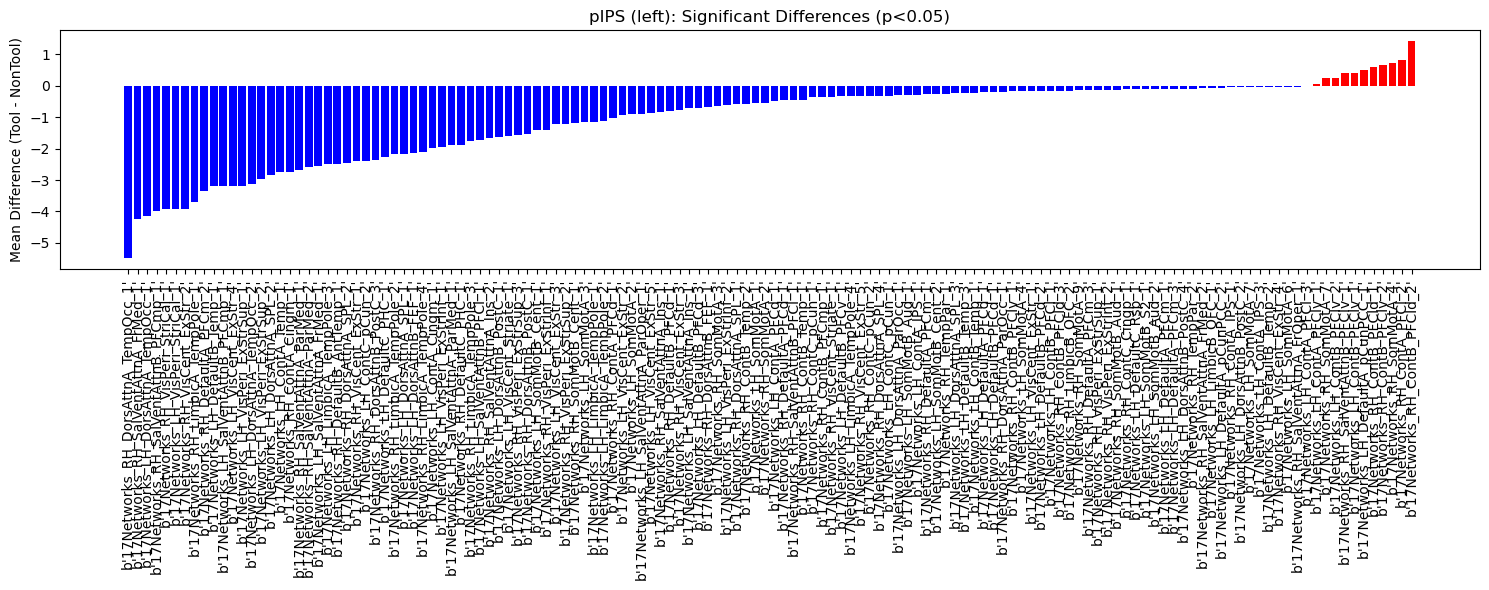

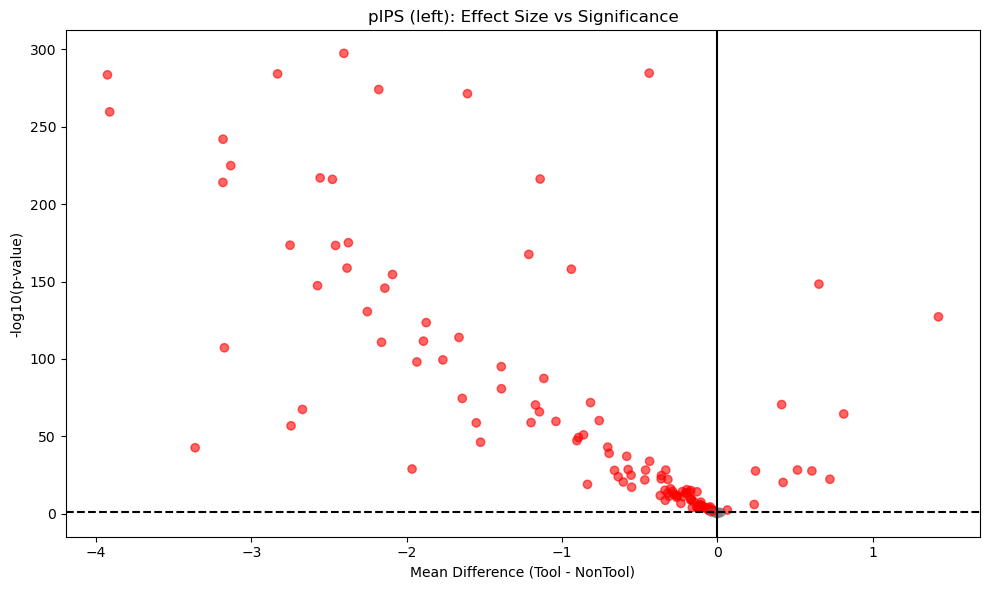

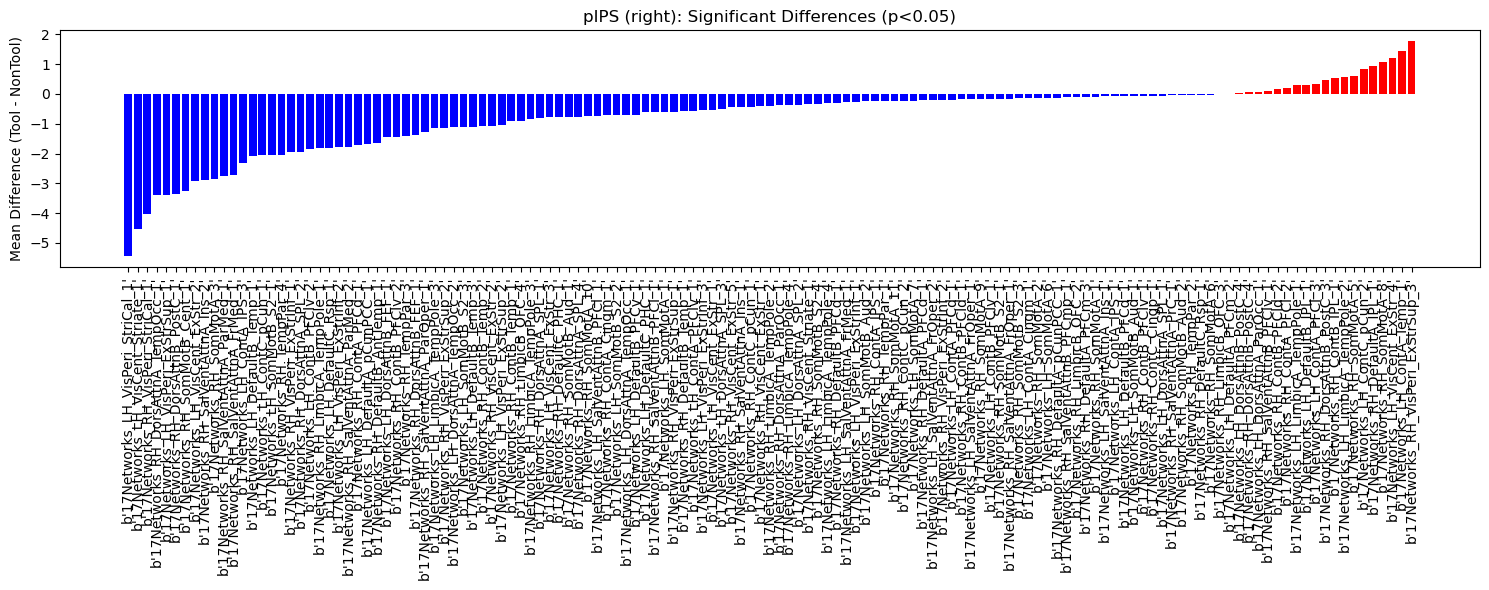

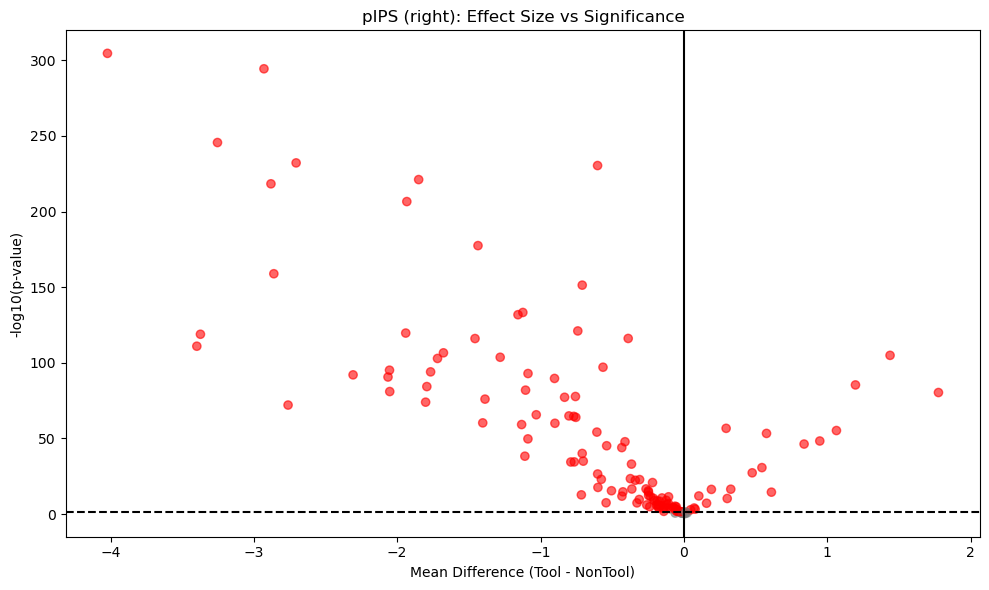

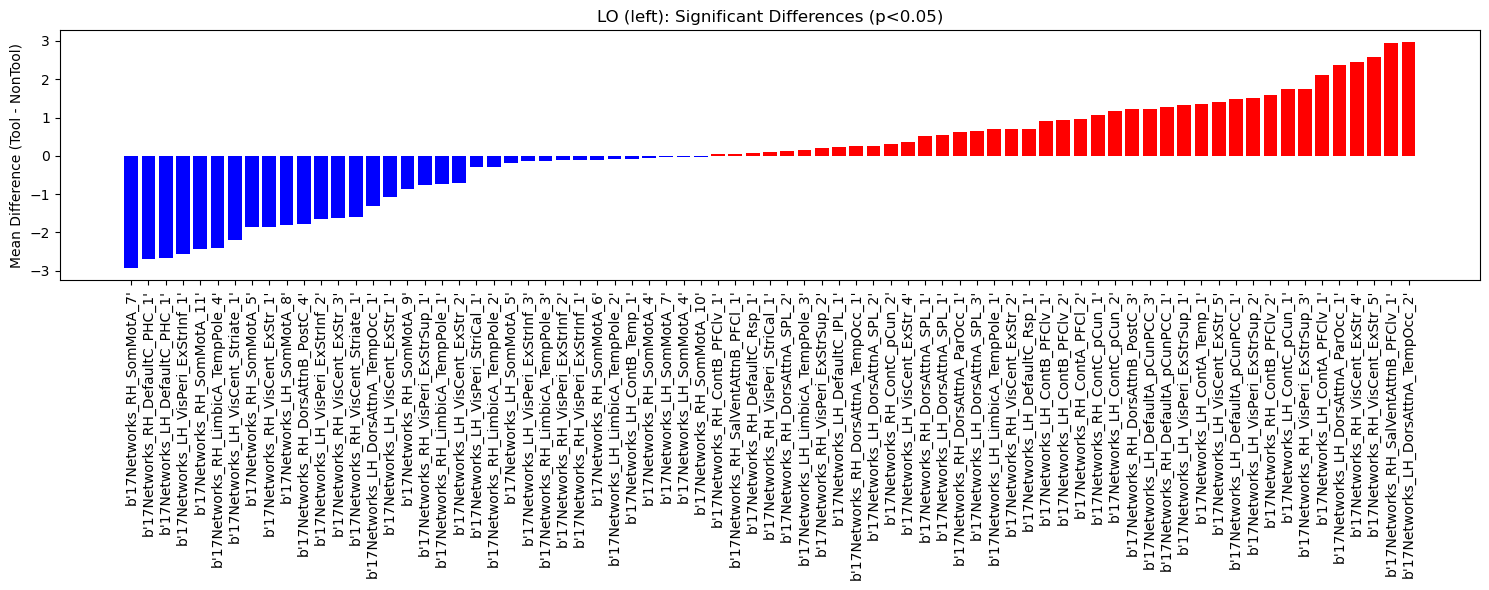

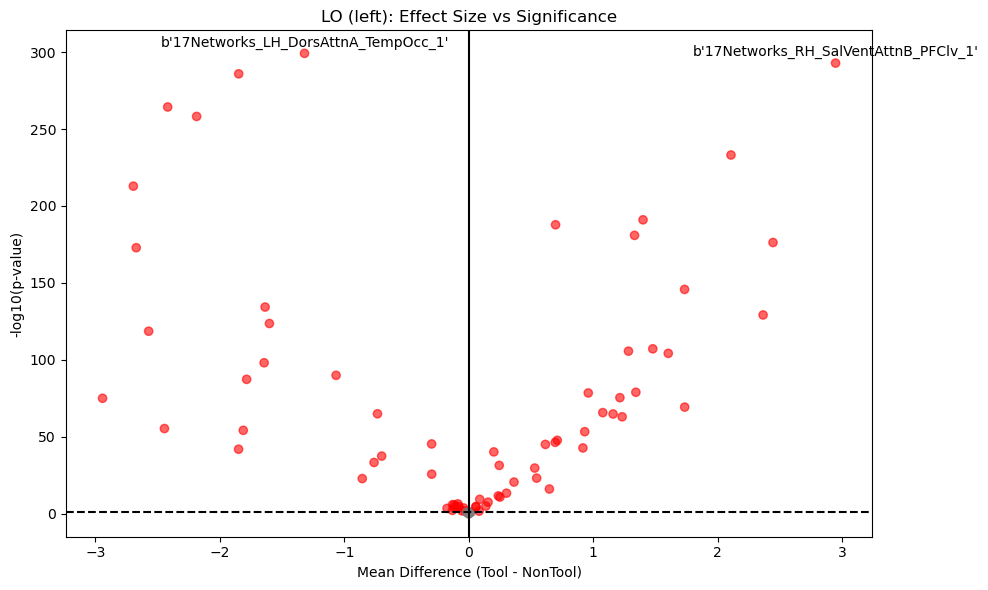

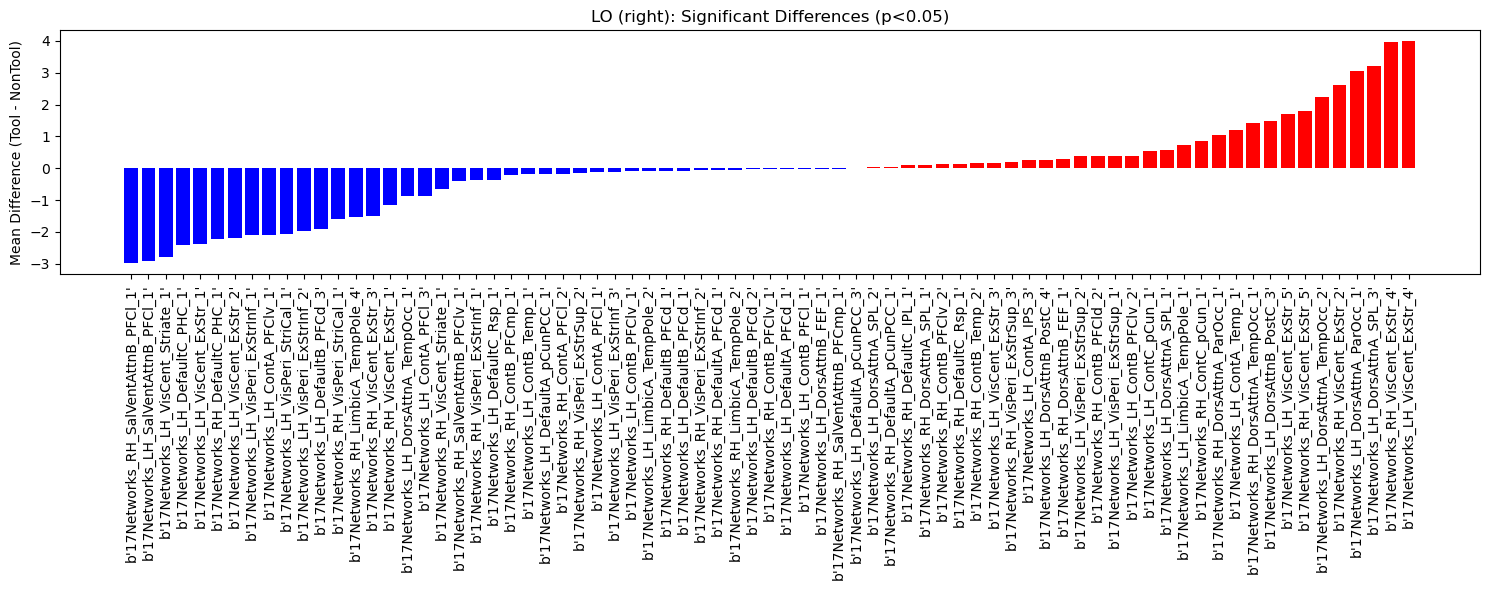

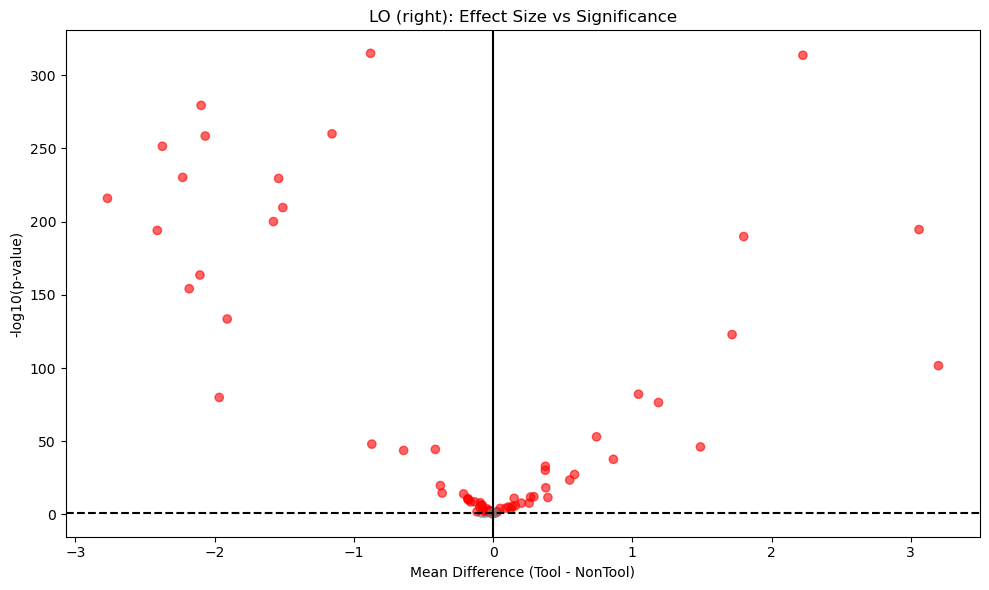

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

def plot_gca_significant_differences(roi_values, atlas_labels, output_dir, alpha=0.05):
    """Identify and visualize ROIs with significant Tool vs NonTool differences"""
    print(f"\n{'='*80}")
    print("TOOL vs NONTOOL SIGNIFICANT DIFFERENCES ANALYSIS")
    print(f"{'='*80}")
    
    # ----------------------------
    # Helper Functions (from original script)
    # ----------------------------
    def clean_roi_name(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        if 'Wang_' in roi_name:
            return roi_name.replace('Wang_', '')
        cleaned = roi_name.replace('7Networks_', '')
        parts = cleaned.split('_')
        if len(parts) > 2:
            return parts[-2] + '_' + parts[-1]
        return parts[-1] if len(parts) > 1 else cleaned
    
    def map_to_anatomical_lobe(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        if 'Wang_pIPS' in roi_name: return 'Parietal'
        if 'Wang_LO' in roi_name: return 'Temporal'
        if 'Vis' in roi_name: return 'Occipital'
        if 'SomMot' in roi_name: return 'Somatomotor'
        if 'DorsAttn' in roi_name: return 'Parietal' if ('Par' in roi_name or 'IP' in roi_name) else 'Temporal'
        if 'SalVentAttn' in roi_name: return 'Insular' if 'Ins' in roi_name else 'Frontal'
        if 'Limbic' in roi_name: return 'Temporal' if 'Temp' in roi_name else 'Frontal'
        if 'Cont' in roi_name: return 'Parietal' if ('Par' in roi_name) else 'Frontal'
        if 'Default' in roi_name: return 'Parietal' if 'Par' in roi_name else 'Frontal'
        return 'Other'
    
    def get_hemisphere_and_region(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        hemisphere = 'L' if 'LH' in roi_name else 'R' if 'RH' in roi_name else 'X'
        cleaned = roi_name.replace('7Networks_', '').replace('LH_', '').replace('RH_', '')
        base_region = re.sub(r'_\d+$', '', cleaned.replace('Wang_', ''))
        return hemisphere, base_region
    # ----------------------------
    
    # Create output directory
    diff_dir = os.path.join(output_dir, 'significant_differences')
    os.makedirs(diff_dir, exist_ok=True)
    
    # 1. Group data by seed region and hemisphere
    seed_groups = {}
    for img_key in roi_values.keys():
        try:
            condition, seed_roi, hemi = img_key.split('_')
        except:
            continue
            
        if 'pIPS' in seed_roi or 'LO' in seed_roi:
            group_key = (seed_roi, hemi)
            if group_key not in seed_groups:
                seed_groups[group_key] = {}
            seed_groups[group_key][condition] = img_key
    
    # 2. Perform statistical comparison for each seed+hemi group
    for (seed_roi, hemi), conditions in seed_groups.items():
        print(f"\nAnalyzing {seed_roi} ({hemi} hemisphere):")
        
        # Check we have both conditions
        if 'tool' not in conditions or 'nontool' not in conditions:
            print(f"  Missing one condition for {seed_roi} {hemi}")
            continue
            
        # Get the data
        tool_data = roi_values[conditions['tool']]
        nontool_data = roi_values[conditions['nontool']]
        
        # Prepare results storage
        results = []
        
        # 3. For each ROI, perform paired statistical test
        common_rois = set(tool_data.keys()) & set(nontool_data.keys())
        for roi_id in common_rois:
            # Get paired values
            tool_vals = tool_data[roi_id]
            nontool_vals = nontool_data[roi_id]
            
            # Create mask for valid paired observations
            mask = (~np.isnan(tool_vals)) & (~np.isnan(nontool_vals)) & \
                   (~np.isinf(tool_vals)) & (~np.isinf(nontool_vals))
            paired_tool = tool_vals[mask]
            paired_nontool = nontool_vals[mask]
            
            if len(paired_tool) < 3:
                continue
                
            # Perform paired t-test
            t_stat, p_val = ttest_rel(paired_tool, paired_nontool)
            mean_diff = np.mean(paired_tool - paired_nontool)
            
            # Get ROI info
            roi_name = atlas_labels[roi_id] if isinstance(roi_id, int) else f"Wang_{roi_id}"
            if isinstance(roi_name, bytes):
                roi_name = roi_name.decode('utf-8')
                
            results.append({
                'ROI_ID': roi_id,
                'ROI_Name': roi_name,
                'Clean_Name': clean_roi_name(roi_name),
                'Mean_Difference': mean_diff,
                'p_value': p_val,
                't_stat': t_stat,
                'Significant': p_val < alpha,
                'Effect_Size': mean_diff / np.std(paired_tool - paired_nontool, ddof=1),
                'N_pairs': len(paired_tool)
            })
        
        if not results:
            print("  No valid ROIs for comparison")
            continue
            
        # Convert to DataFrame
        df = pd.DataFrame(results)
        
        # Add anatomical info
        df['Lobe'] = df['ROI_Name'].apply(map_to_anatomical_lobe)
        df['Hemisphere'] = df['ROI_Name'].apply(lambda x: get_hemisphere_and_region(x)[0])
        
        # Save raw results
        df.to_csv(os.path.join(diff_dir, f'{seed_roi}_{hemi}_stats.csv'), index=False)
        
        # 4. Create visualizations
        
        # A) Bar plot of significant differences
        plt.figure(figsize=(15, 6))
        sig_df = df[df['Significant']].sort_values('Mean_Difference')
        
        if len(sig_df) > 0:
            colors = ['red' if x > 0 else 'blue' for x in sig_df['Mean_Difference']]
            plt.bar(range(len(sig_df)), sig_df['Mean_Difference'], color=colors)
            plt.xticks(range(len(sig_df)), sig_df['Clean_Name'], rotation=90)
            plt.ylabel('Mean Difference (Tool - NonTool)')
            plt.title(f'{seed_roi} ({hemi}): Significant Differences (p<{alpha})')
            plt.tight_layout()
            #plt.savefig(os.path.join(diff_dir, f'{seed_roi}_{hemi}_sig_bars.png'), dpi=300)
            #plt.close()
        
        # B) Volcano plot
        plt.figure(figsize=(10, 6))
        plt.scatter(df['Mean_Difference'], -np.log10(df['p_value']),
                   c=['red' if s else 'gray' for s in df['Significant']],
                   alpha=0.6)
        plt.axhline(-np.log10(alpha), color='k', linestyle='--')
        plt.axvline(0, color='k')
        plt.xlabel('Mean Difference (Tool - NonTool)')
        plt.ylabel('-log10(p-value)')
        plt.title(f'{seed_roi} ({hemi}): Effect Size vs Significance')
        
        # Annotate top significant ROIs
        for _, row in df.nsmallest(5, 'p_value').iterrows():
            plt.annotate(row['Clean_Name'], 
                        (row['Mean_Difference'], -np.log10(row['p_value'])),
                        textcoords="offset points",
                        xytext=(0,5), ha='center')
        
        plt.tight_layout()
        #plt.savefig(os.path.join(diff_dir, f'{seed_roi}_{hemi}_volcano.png'), dpi=300)
        #plt.close()
        
        print(f"  Saved results for {seed_roi} {hemi}")

# Run the analysis
plot_gca_significant_differences(roi_values, atlas_labels, output_dir)

In [40]:
from scipy.stats import ttest_rel
import numpy as np

def analyze_significant_changes(roi_values, atlas_labels, alpha=0.05):
    """Robust analysis of significant changes with proper edge case handling"""
    print("\nROBUST SIGNIFICANT VALUE CHANGES")
    print("ROI_ID\tName\tTool\tNonTool\tChange\tMagnitude\tp-value\tSig\tN_pairs")
    
    # Get condition keys
    tool_key = next(k for k in roi_values.keys() if 'tool' in k.lower())
    nontool_key = next(k for k in roi_values.keys() if 'nontool' in k.lower())
    
    for roi_id in sorted(roi_values[tool_key].keys()):
        # Get ROI name
        roi_name = atlas_labels[roi_id] if isinstance(roi_id, int) else f"Wang_{roi_id}"
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Get paired values and clean
        tool_vals = roi_values[tool_key][roi_id]
        nontool_vals = roi_values[nontool_key][roi_id]
        mask = (~np.isnan(tool_vals)) & (~np.isnan(nontool_vals)) & \
               (~np.isinf(tool_vals)) & (~np.isinf(nontool_vals))
        tool_clean = tool_vals[mask]
        nontool_clean = nontool_vals[mask]
        n_pairs = len(tool_clean)
        
        # Skip if insufficient data
        if n_pairs < 3:
            continue
            
        # Calculate means and absolute difference
        tool_mean = np.mean(tool_clean)
        nontool_mean = np.mean(nontool_clean)
        mean_diff = tool_mean - nontool_mean
        abs_diff = abs(mean_diff)
        
        # Only calculate p-value if there's actual variation
        if np.all(tool_clean == nontool_clean):
            p_value = 1.0
            is_sig = False
            change = "NoChange"
        else:
            _, p_value = ttest_rel(tool_clean, nontool_clean)
            is_sig = p_value < alpha
            
            # Classify change only if magnitude > 0
            if abs_diff > 1e-6:  # Floating point tolerance
                if tool_mean > 0 and nontool_mean > 0:
                    change = "Positive++" if mean_diff > 0 else "Positive--"
                elif tool_mean < 0 and nontool_mean < 0:
                    change = "Negative++" if mean_diff > 0 else "Negative--"
                elif tool_mean > 0 and nontool_mean < 0:
                    change = "Flip:Pos→Neg"
                elif tool_mean < 0 and nontool_mean > 0:
                    change = "Flip:Neg→Pos"
                else:
                    change = "ZeroCross"
            else:
                change = "NoChange"
                is_sig = False  # Can't be significant if no change
        
        print(f"{roi_id}\t{roi_name}\t{tool_mean:.3f}\t{nontool_mean:.3f}\t"
              f"{change}\t{abs_diff:.3f}\t{p_value:.4f}\t{'*' if is_sig else ''}\t{n_pairs}")

# Example usage:
analyze_significant_changes(roi_values, atlas_labels)


ROBUST SIGNIFICANT VALUE CHANGES
ROI_ID	Name	Tool	NonTool	Change	Magnitude	p-value	Sig	N_pairs
b'17Networks_LH_ContA_Cingm_1'	Wang_b'17Networks_LH_ContA_Cingm_1'	0.000	1.966	ZeroCross	1.966	0.0000	*	164
b'17Networks_LH_ContA_IPS_1'	Wang_b'17Networks_LH_ContA_IPS_1'	0.088	0.369	Positive--	0.281	0.0000	*	647
b'17Networks_LH_ContA_IPS_2'	Wang_b'17Networks_LH_ContA_IPS_2'	0.000	0.000	NoChange	0.000	1.0000		430
b'17Networks_LH_ContA_IPS_3'	Wang_b'17Networks_LH_ContA_IPS_3'	0.278	0.324	Positive--	0.046	0.0200	*	408
b'17Networks_LH_ContA_PFCd_1'	Wang_b'17Networks_LH_ContA_PFCd_1'	0.000	0.467	ZeroCross	0.467	0.0000	*	586
b'17Networks_LH_ContA_PFCl_1'	Wang_b'17Networks_LH_ContA_PFCl_1'	0.019	0.011	Positive++	0.008	0.3655		829
b'17Networks_LH_ContA_PFCl_2'	Wang_b'17Networks_LH_ContA_PFCl_2'	0.000	0.000	NoChange	0.000	1.0000		414
b'17Networks_LH_ContA_PFCl_3'	Wang_b'17Networks_LH_ContA_PFCl_3'	0.000	0.017	ZeroCross	0.017	0.0455	*	671
b'17Networks_LH_ContA_PFClv_1'	Wang_b'17Networks_LH_ContA_PFCl